<img src='harrypotter_image.png' width='200px' style="float:left;margin-right:10pt"></img>
## Illustration of NWHypergraph <-> HyperNetX exchange using PyBind and Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. We also use PyBind to communicate with a C++ function in PNNL's **NWHypergraph (NWHy)** library to illustrate our current work to optimize HyperNetX for large datasets.

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in this tutorial's directory.

In [1]:
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import scipy
from scipy.sparse import coo_matrix, csr_matrix, issparse
import pandas as pd
import numpy as np
import itertools as it
# import nwhy    ##### library loaded in this Docker container, not yet available for distribution
import sys
from harrypotter import HarryPotter

In [2]:
import importlib as imp

In [3]:
harryp = HarryPotter()
harryp.dataframe

,House,Blood status,Species,Hair colour,Eye colour
0,Gryffindor,Half-blood,Human,Black,Bright green
1,Gryffindor,Pure-blood,Human,Red,Blue
2,Gryffindor,Muggle-born,Human,Brown,Brown
3,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
4,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
135,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
136,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
137,Unknown House,Pure-blood or half-blood,Human,Blond,Blue
138,Unknown House,Unknown Blood status,Elf,Unknown Hair colour,Unknown Eye colour


In [4]:
E = hnx.StaticEntitySet(entity=harryp.dataframe,level1=0,level2=1)
H = hnx.Hypergraph(E, use_nwhy=True)

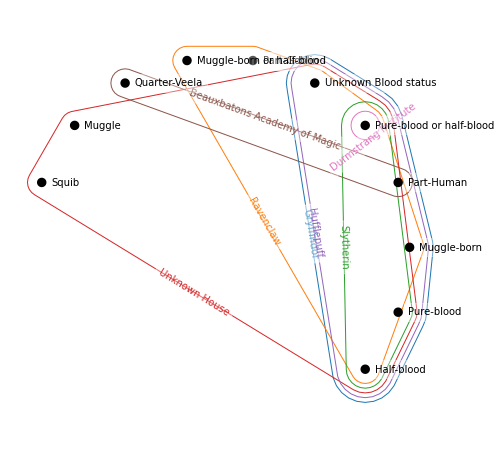

In [5]:
hnx.draw(H,layout=nx.shell_layout)

In [6]:
## to compute distribution stats:
g = H.state_dict['g']
g.edge_size_dist(),g.node_size_dist()

([6, 6, 3, 6, 5, 2, 1], [5, 4, 3, 2, 6, 4, 1, 1, 1, 1, 1])

In [7]:

H.degree('Pure-blood',s=10)

0.0

In [8]:
node = 'Pure-blood'
H.get_id(node)

1

In [9]:
H.size('Ravenclaw')

6

In [10]:
id = H.get_id('Gryffindor',edges=True)
H.g.edge_size_dist()[id]

6

In [11]:
H.get_name(id,edges=True)

'Gryffindor'

In [12]:
H.get_id('Quarter-Veela')

8

In [13]:
H.get_name(H.edges.data.T[0][27],edges=True)

'Beauxbatons Academy of Magic'

In [14]:
H.edges.data[27]

array([5, 8])

In [15]:
mat,rdict,cdict = H.incidence_matrix(index=True)
rdict

{0: 'Half-blood',
 1: 'Pure-blood',
 2: 'Muggle-born',
 3: 'Part-Human',
 4: 'Pure-blood or half-blood',
 5: 'Unknown Blood status',
 6: 'Part-Goblin',
 7: 'Muggle-born or half-blood',
 8: 'Quarter-Veela',
 9: 'Muggle',
 10: 'Squib'}

In [16]:
##  ids of edges containing 8
ids = np.nonzero(H.edges.data.T[1] == H.get_id('Quarter-Veela'))
print(ids)
[H.get_name(id) for id in H.edges.data.T[0][ids]]

(array([27]),)


['Unknown Blood status']

In [17]:
dict(enumerate(H.edges.labs(0)))

{0: 'Gryffindor',
 1: 'Ravenclaw',
 2: 'Slytherin',
 3: 'Unknown House',
 4: 'Hufflepuff',
 5: 'Beauxbatons Academy of Magic',
 6: 'Durmstrang Institute'}

In [18]:
ids = np.where(np.array(H.edge_size_dist()) >= 2)[0]

In [19]:
np.nonzero(H.edges.data.T[1] == 0)[0]

array([ 0,  6, 12, 15, 21])

In [20]:
H.edge_size_dist()

[6, 6, 3, 6, 5, 2, 1]

In [21]:
H.nodes.elements

{'Half-blood': {},
 'Pure-blood': {},
 'Muggle-born': {},
 'Part-Human': {},
 'Pure-blood or half-blood': {},
 'Unknown Blood status': {},
 'Part-Goblin': {},
 'Muggle-born or half-blood': {},
 'Quarter-Veela': {},
 'Muggle': {},
 'Squib': {}}

In [22]:
HD = H.remove_static()

In [23]:
HD.edges

EntitySet(:Edges,['Slytherin', 'Gryffindor', 'Ravenclaw', 'Beauxbatons Academy of Magic', 'Hufflepuff', 'Unknown House', 'Durmstrang Institute'],{})

In [24]:
HD.nodes

EntitySet(:Nodes,['Unknown Blood status', 'Muggle', 'Pure-blood or half-blood', 'Muggle-born or half-blood', 'Part-Goblin', 'Squib', 'Quarter-Veela', 'Part-Human', 'Muggle-born', 'Pure-blood', 'Half-blood'],{})

In [25]:
g = H.state_dict['g']
g.number_of_edges()

7

In [26]:
g.number_of_edges.__name__

'number_of_edges'

In [27]:
type(g)

nwhy.NWHypergraph

In [28]:
g.col

array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
        4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4], dtype=int32)

In [29]:
g.degree(1)

4

In [30]:
type(g).degree(g,9)

1

In [31]:
H.nodes

StaticEntitySet(None,['Unknown Blood status', 'Muggle', 'Pure-blood or half-blood', 'Muggle-born or half-blood', 'Part-Goblin', 'Squib', 'Quarter-Veela', 'Part-Human', 'Muggle-born', 'Pure-blood', 'Half-blood'],{})

In [32]:
{e:H.degree(e) for e in H.nodes}

{'Half-blood': 5,
 'Pure-blood': 4,
 'Muggle-born': 3,
 'Part-Human': 2,
 'Pure-blood or half-blood': 6,
 'Unknown Blood status': 4,
 'Part-Goblin': 1,
 'Muggle-born or half-blood': 1,
 'Quarter-Veela': 1,
 'Muggle': 1,
 'Squib': 1}

In [33]:
type(g)

nwhy.NWHypergraph

In [34]:
M = H.s_connected_components(s=2)

In [35]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
          4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {},
 'g': <nwhy.NWHypergraph at 0x7fada09acd30>,
 'edge_size_dist': [6, 6, 3, 6, 5, 2, 1],
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>}

In [36]:
S = H.get_linegraph(2)

In [37]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
          4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {2: <nwhy.Slinegraph at 0x7fad50befc30>},
 'g': <nwhy.NWHypergraph at 0x7fada09acd30>,
 'edge_size_dist': [6, 6, 3, 6, 5, 2, 1],
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>}

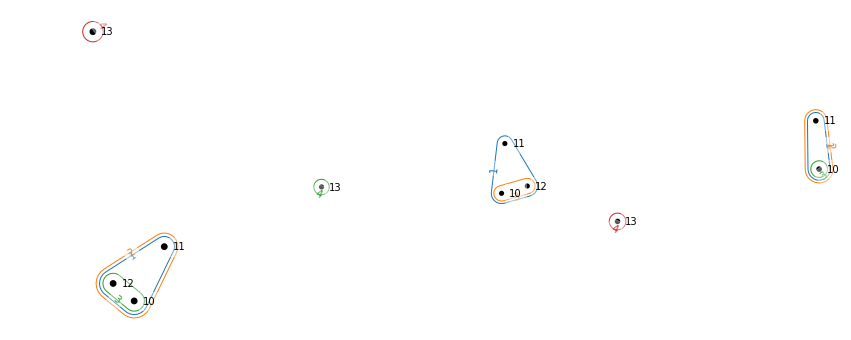

In [38]:
d = OrderedDict({1:[10,11,12],2:[10,11,12],3:[10,12],4:[13]})
hd = hnx.Hypergraph(d,static=True, use_nwhy=True)
# Hc = hnx.Hypergraph(hd.edges.collapse_identical_elements('_'))
fig,ax = plt.subplots(1,3, figsize=(15,6))
hnx.draw(hd,ax=ax[0])
hnx.draw(hd.collapse_edges(),ax=ax[1])
hnx.draw(hd.collapse_nodes(),ax=ax[2])

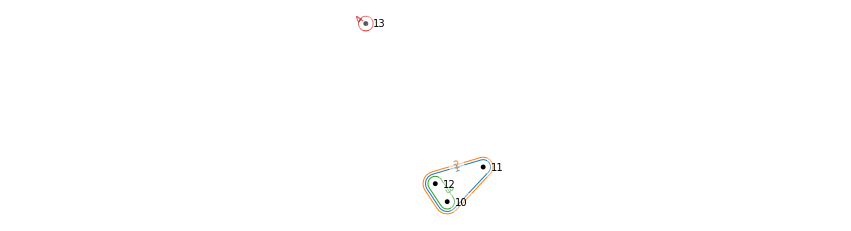

In [39]:
d = OrderedDict({1:[10,11,12],2:[10,11,12],3:[10,12],4:[13]})
hd = hnx.Hypergraph(d,static=True, use_nwhy=True)
plt.subplots(figsize=(15,4))
hnx.draw(hd)

In [40]:
g = hd.get_linegraph(1,edges=False)
diameters=[]
for c in g.s_connected_components():
    print(c)
    tc = hd.edges.labs(1)[list(c)]
    print(tc)
    print(hd.restrict_to_nodes(tc))
    break

{0, 1, 2}
[10 11 12]
Hypergraph(OrderedDict([(1, [10, 11, 12]), (2, [10, 11, 12]), (3, [10, 12])]),name=)


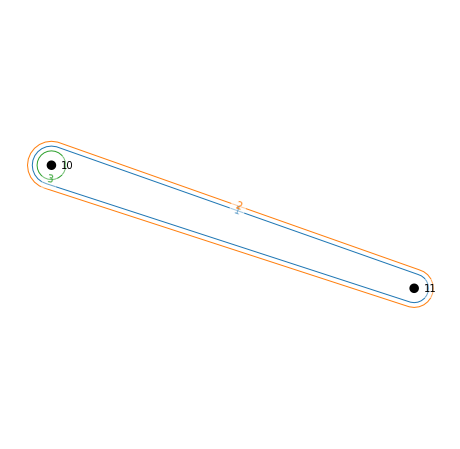

In [41]:
g = hd.restrict_to_nodes([10,11])
hnx.draw(g)

In [42]:
H.edges.labs(0)

array(['Gryffindor', 'Ravenclaw', 'Slytherin', 'Unknown House',
       'Hufflepuff', 'Beauxbatons Academy of Magic',
       'Durmstrang Institute'], dtype='<U28')

In [43]:
Hr = H.restrict_to_edges(['Gryffindor','Ravenclaw'])
Hr

Hypergraph(OrderedDict([('Gryffindor', ['Half-blood', 'Pure-blood', 'Muggle-born', 'Part-Human', 'Pure-blood or half-blood', 'Unknown Blood status']), ('Ravenclaw', ['Half-blood', 'Muggle-born', 'Pure-blood or half-blood', 'Unknown Blood status', 'Part-Goblin', 'Muggle-born or half-blood'])]),name=)

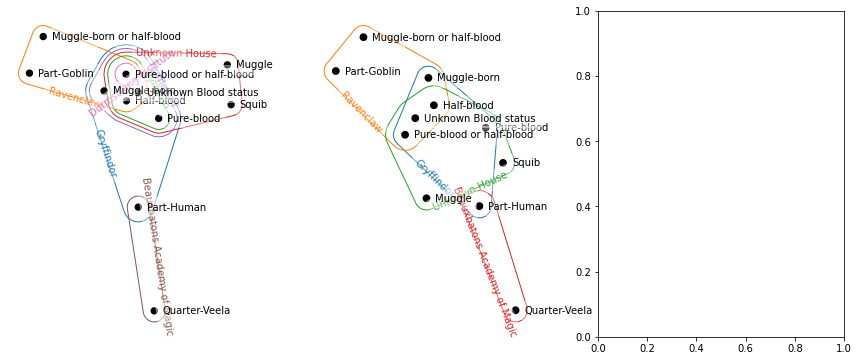

In [44]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
hnx.draw(H.toplexes(),ax=ax[1])
hnx.draw(H,ax=ax[0])

In [45]:
H.edges.translate(0,H.g.toplexes())

['Slytherin', 'Durmstrang Institute']

In [46]:
H.toplexes().edges.uidset

frozenset({'Beauxbatons Academy of Magic',
           'Gryffindor',
           'Ravenclaw',
           'Unknown House'})

In [47]:
H.edges['Gryffindor']

['Half-blood',
 'Pure-blood',
 'Muggle-born',
 'Part-Human',
 'Pure-blood or half-blood',
 'Unknown Blood status']

In [48]:
H.distance('Pure-blood','Squib',s=1)

1

In [49]:
HD = H.remove_static()

In [50]:
HG = hnx.Hypergraph(setsystem=HD.edges,static=True)

In [51]:
HG

Hypergraph(OrderedDict([('Gryffindor', ['Unknown Blood status', 'Pure-blood or half-blood', 'Part-Human', 'Muggle-born', 'Pure-blood', 'Half-blood']), ('Ravenclaw', ['Unknown Blood status', 'Pure-blood or half-blood', 'Muggle-born', 'Half-blood', 'Muggle-born or half-blood', 'Part-Goblin']), ('Slytherin', ['Pure-blood or half-blood', 'Pure-blood', 'Half-blood']), ('Unknown House', ['Unknown Blood status', 'Pure-blood or half-blood', 'Pure-blood', 'Half-blood', 'Muggle', 'Squib']), ('Hufflepuff', ['Unknown Blood status', 'Pure-blood or half-blood', 'Muggle-born', 'Pure-blood', 'Half-blood']), ('Beauxbatons Academy of Magic', ['Part-Human', 'Quarter-Veela']), ('Durmstrang Institute', ['Pure-blood or half-blood'])]),name=)

In [52]:
HG.distance('Pure-blood','Squib',s=2)

/Users/prag717/Documents/tdm/hnx/hypernetx/classes/hypergraph.py:1743: UserWarning: No 2-path between Pure-blood and Squib
  warnings.warn(f'No {s}-path between {source} and {target}')


inf

In [53]:
H.g.edge_size_dist()

[6, 6, 3, 6, 5, 2, 1]

In [54]:
hnx.edge_size_dist(H)

[6, 6, 3, 6, 5, 2, 1]

In [55]:
H.g.node_size_dist()

[5, 4, 3, 2, 6, 4, 1, 1, 1, 1, 1]

In [56]:
hnx.degree_dist(H)

[5, 4, 3, 2, 6, 4, 1, 1, 1, 1, 1]

In [57]:
list(np.array(np.sum(H.incidence_matrix(), axis=0))[0])

[6, 6, 3, 6, 5, 2, 1]

In [58]:
HS = H.remove_static()
[HS.size(e) for e in HS.edges]

[6, 6, 3, 6, 5, 2, 1]

In [59]:
hnx.s_comp_dist(H)

[7]

In [60]:
[H.size(e) for e in H.toplexes().edges]

[6, 6, 6, 2]

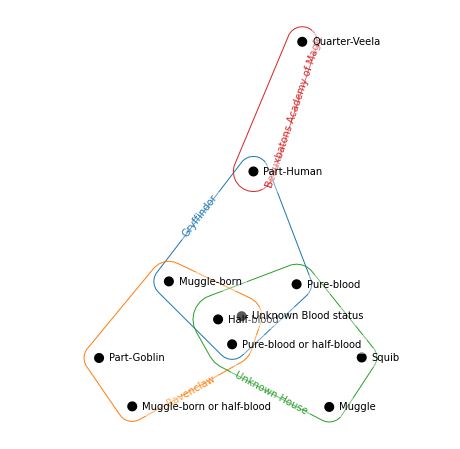

In [61]:
hnx.draw(H.toplexes())

In [62]:
H.edges

StaticEntitySet(None,['Slytherin', 'Gryffindor', 'Ravenclaw', 'Beauxbatons Academy of Magic', 'Hufflepuff', 'Unknown House', 'Durmstrang Institute'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])})

In [63]:
edges=False
obj='Squib'
ldx = (edges*1+1)%2
idx = int(np.argwhere(H.nodes.labs(0) == obj))
# if idx == 0:          
H.edges.labs(0)[np.nonzero(H.incidence_matrix()[idx,:])[0]]

array(['Gryffindor'], dtype='<U28')

In [64]:
H.nodes.labs(0)

array(['Half-blood', 'Pure-blood', 'Muggle-born', 'Part-Human',
       'Pure-blood or half-blood', 'Unknown Blood status', 'Part-Goblin',
       'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
      dtype='<U25')

In [65]:
H.incidence_matrix().todense()

matrix([[1, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]])

In [66]:
H.dual()['Gryffindor']

['Ravenclaw',
 'Slytherin',
 'Unknown House',
 'Hufflepuff',
 'Beauxbatons Academy of Magic',
 'Durmstrang Institute']

In [67]:
list(H.dual().edges['Squib'])

['Unknown House']

In [68]:
list(H.remove_static().dual().edges['Squib'])

['Unknown House']

In [69]:
list(H.remove_static().edges['Gryffindor'])

['Half-blood',
 'Pure-blood',
 'Muggle-born',
 'Part-Human',
 'Pure-blood or half-blood',
 'Unknown Blood status']

In [70]:
s = 4
nd = 'Part-Human'
idx = H.nodes.index(H.nodes.keys[0],nd)[1]
H.remove_static().degree(nd,s=s), H.g.degree(idx,size=s)

(1, 2)

In [71]:
for e in H.edges:
    edx = H.edges.index(H.edges.keys[0],e)[1]
    print(H.g.size(edx),H.size(e), H.get_id(e,edges=True))


6 6 0
6 6 1
3 3 2
6 6 3
5 5 4
2 2 5
1 1 6


In [72]:
H.edges.index(H.edges.keys[0],e)[1]

6

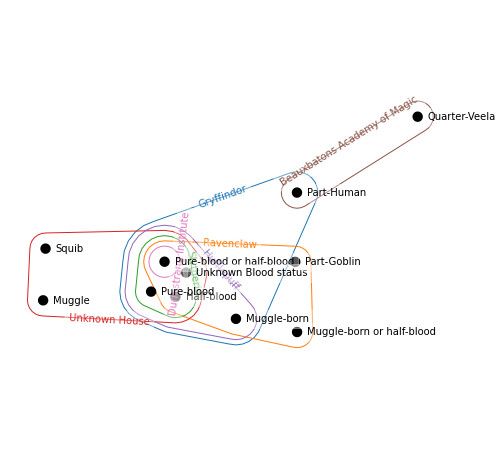

In [73]:
hnx.draw(H)

In [77]:
hnx.s_eccentricity(H)

{'Gryffindor': 1,
 'Ravenclaw': 2,
 'Slytherin': 2,
 'Unknown House': 2,
 'Hufflepuff': 2,
 'Beauxbatons Academy of Magic': 2,
 'Durmstrang Institute': 2}